In [1]:
import torch
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
import pandas as pd
import math as m



In [3]:
%load_ext autoreload
%autoreload 2

In [7]:
from src.data import get_nonlinear_data,hopf
from src.edmd import TruncEDMD, KernelEDMD, DMD 
from src.kernels import  PolynomialKernel
from src.visualizations import  OOS_tradjectory,legend_without_duplicate_labels,gridsearch,dynamicshopf
from matplotlib.legend_handler import HandlerTuple

In [3]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

Plot the Original System

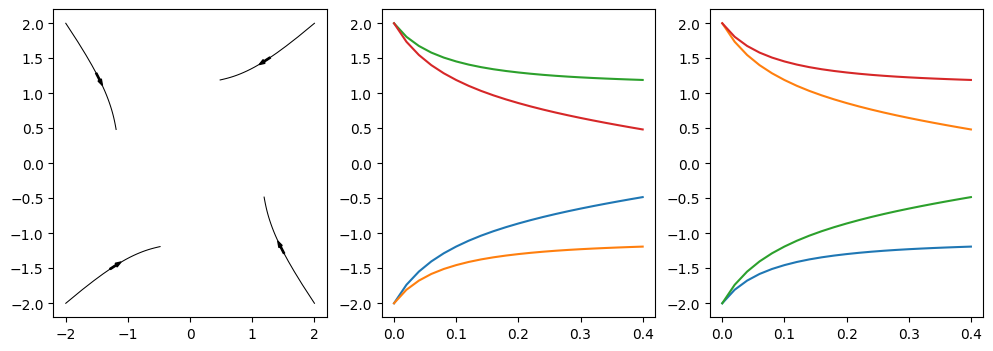

In [5]:
dynamic_system="hopf"
f, ax = plt.subplots(1, 3, figsize=(12, 4))
timesteps=21
t_end=0.4
t_eval=np.linspace(0, t_end, timesteps)
df_Original=pd.DataFrame()
factor=1


initial_conditions = np.array(np.meshgrid(np.linspace(-2, 2,2), np.linspace(-2, 2, 2))).T.reshape(-1, 2)

x = np.zeros((len(initial_conditions)*(timesteps-1), 2))
y = np.zeros((len(initial_conditions)*(timesteps-1), 2))
original= np.zeros((len(initial_conditions)*(timesteps), 2))

x,y,original,t_eval_frac=dynamicshopf(hopf,initial_conditions,t_end,timesteps,factor)


for ic, condition in enumerate(initial_conditions):
   
    
    ax[0].plot(original[ic*(timesteps):ic*(timesteps)+(timesteps), 0],original[ic*(timesteps):ic*(timesteps)+(timesteps), 1],
               color="black",linewidth=0.75)
    x=original[ic*(timesteps)+(timesteps)//5, 0]
    y=original[ic*(timesteps)+(timesteps)//5, 1]
    dx=original[ic*(timesteps)+(timesteps)//5+1, 0]-original[ic*(timesteps)+(timesteps)//5, 0]
    dy=original[ic*(timesteps)+(timesteps)//5+1, 1]-original[ic*(timesteps)+(timesteps)//5, 1]
    ax[0].arrow(x,y,dx,dy,width=0.02,color="black")
    ax[1].plot(t_eval,original[ic*(timesteps):ic*(timesteps)+(timesteps), 0])
    ax[2].plot(t_eval,original[ic*(timesteps):ic*(timesteps)+(timesteps), 1])
    


Perform Grid Search to find optimal parameters

In [10]:

initial_conditions = np.array(np.meshgrid(np.linspace(-2,2,3), np.linspace(-2, 2,3))).T.reshape(-1, 2)
initial_conditions_sample=np.array([[1.5,1.5],[0.75,0.75],[-.4,-0.4]])
method = TruncEDMD()
parameters = np.array([None]) #put None here if no paramters
truncs=np.array([2,3,4,5])#np.array([2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
#steps=np.arange(100,500,50)
factors=np.arange(1,3,1)#np.arange(1,15,1)
#grid=np.empty(len(factors),len(truncs))
timesteps=40
t_end=0.4#0.0006
kernel = PolynomialKernel()
index=0


lossperstep,OOSlossperstep,optim=gridsearch(factors,truncs,parameters,initial_conditions,
                                            initial_conditions_sample,timesteps,t_end,method,kernel,hopf)



Plot the results of the grid search

[1 2]


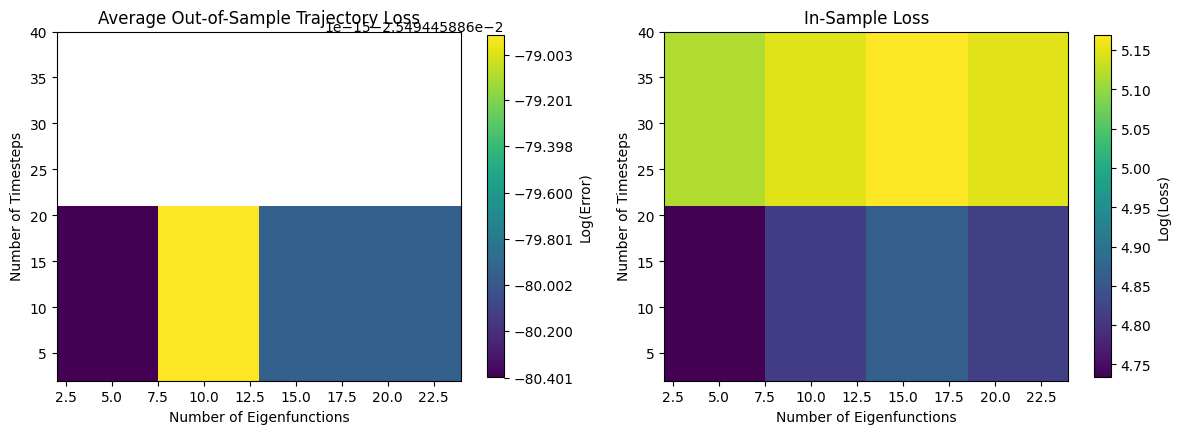

(array([1], dtype=int64), array([0], dtype=int64))


In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 

# Plot the first image in the first subplot
im1 = ax[0].imshow(np.log(OOSlossperstep),extent=[2,24,2,40],aspect=0.5)

cbar1 = fig.colorbar(im1, ax=ax[0],shrink=0.6)  

ax[0].set_xlabel("Number of Eigenfunctions")
ax[0].set_ylabel("Number of Timesteps")

ax[0].set_title("Average Out-of-Sample Trajectory Loss") 
cbar1.set_label("Log(Error)")
# Plot the second image in the second subplot
im2 = ax[1].imshow(np.log(lossperstep),extent=[2,24,2,40],aspect=0.5)
cbar2 = fig.colorbar(im2, ax=ax[1],shrink=0.6)  
#cbar2.set_label("Loss per Step")
ax[1].set_xlabel("Number of Eigenfunctions")
ax[1].set_ylabel("Number of Timesteps")
ax[1].set_title("In-Sample Loss")  
cbar2.set_label("Log(Loss)")

min=np.where(optim == np.nanmin(optim))

plt.tight_layout()
print(factors)

plt.show()
print(min)

Plot and report the in-sample and out of sample loss for the best paramter combination

loss tensor(2.3512e-07, dtype=torch.float64)


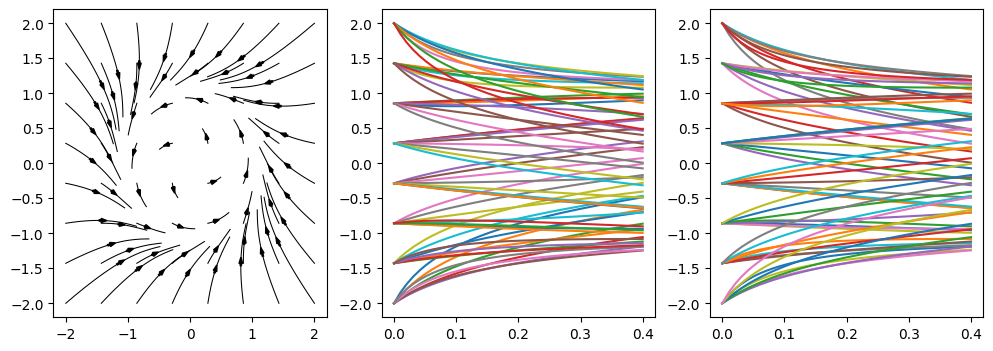

In [14]:

initial_conditions = np.array(np.meshgrid(np.linspace(-2,2,8), np.linspace(-2, 2,8))).T.reshape(-1, 2)
t_end=0.4#0.0006
timesteps=40

dt=t_end/timesteps
t_eval=np.linspace(0, t_end, timesteps)
trunc=12
factor=1
method = TruncEDMD()

  
kernel = PolynomialKernel()

x,y,original,t_eval=dynamicshopf(hopf,initial_conditions,t_end,timesteps,factor)
Kernel_results=method.edmd_computations(x.T,y.T,kernel,trunc)

method.preloss_computation_full()
loss = method.loss_full(kernel, x.T, y.T, penalty=True)

f, ax = plt.subplots(1, 3, figsize=(12, 4))

for ic,condition in enumerate(initial_conditions):

    condition=np.array([condition],ndmin=2)
    Fx=method.single_tradjectory(t_eval,condition.T,x.T,y.T,kernel,Kernel_results) 
    
    ax[0].plot(Fx[:,0],Fx[:,1],color="black",linewidth=0.75)
    ax[1].plot(t_eval,Fx[:,0])
    ax[2].plot(t_eval,Fx[:,1])
    x1=Fx[(timesteps//4), 0]
    y1=Fx[(timesteps//4), 1]
    dx=Fx[(timesteps//4+1), 0]-Fx[(timesteps//4), 0]
    dy=Fx[(timesteps//4+1), 1]-Fx[(timesteps//4), 1]
    ax[0].arrow(x1,y1,dx,dy,width=0.02,color="black")

print("loss",loss)


L2_norm 0.020007080589967953
L2_norm 0.020007080589967953


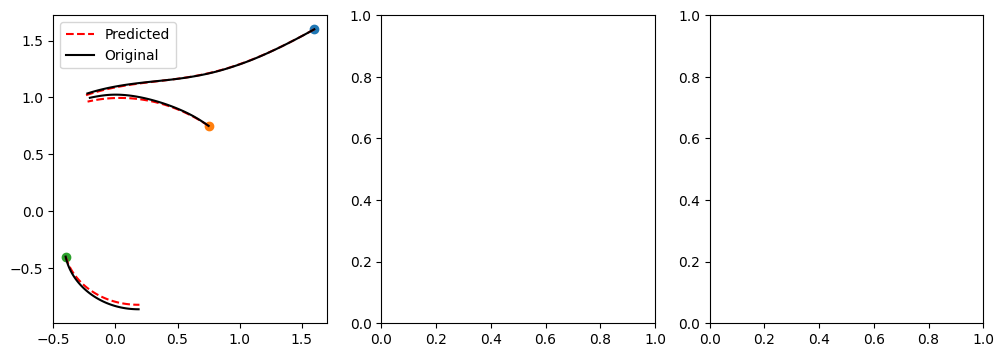

In [23]:

#out of sample specification#################################################################   
f, ax = plt.subplots(1, 3, figsize=(12, 4))
timesteps_sample=100
t_end_sample =timesteps_sample*dt

t_eval_sample = np.linspace(0, t_end_sample, timesteps_sample)
initial_conditions_sample=np.array([[1.6,1.6],[0.75,0.75],[-.4,-0.4]])
#line=np.empty(len(initial_conditions_sample))
#print(initial_conditions)
#dynamics_norm,intial_conditions_norm_sample=OOS_system_normalize(t_eval_sample,initial_conditions_sample,original,get_nonlinear_chem_CO_Single2)
#RBF_Kernel_results=method.edmd_computations(x[0*(timesteps-1) :0*(timesteps-1)+(timesteps-1), :].T,
                                               #y[0*(timesteps-1) :0*(timesteps-1)+(timesteps-1), :].T,kernel)
sumloss=0
for ic,condition in enumerate(initial_conditions_sample):
       
        solution,df=get_nonlinear_data(t_eval_sample,condition,hopf)
                
        condition=np.array([condition],ndmin=2)
        
        predicted=method.single_tradjectory(t_eval_sample,condition.T,x.T,y.T,kernel,Kernel_results)   
        sumloss = sumloss+np.sqrt(np.sum(np.square(predicted-solution))/len(t_eval_sample))
        
        ax[0].plot(predicted[:,0],predicted[:,1],0.1,c="red",linestyle='--', label="Predicted" )   
        ax[0].plot(solution[:,0],solution[:,1],0.1,c="black", label="Original" )  
        ax[0].scatter(condition[:,0],condition[:,1]) 
                
                
        legend_without_duplicate_labels(ax[0])
l2=sumloss/len(initial_conditions_sample)          
#print(predicted)
#Compute Relative L2 Error

print("L2_norm",l2)  
#Compute Relative L2 Error
l2=sumloss/len(initial_conditions_sample)    
print("L2_norm",l2)     
   
